# Algorithmic Trading with Bollinger Bands

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
import yfinance as yf
import pandas_datareader as pdr
import tensorflow as tf

In [2]:
tickers_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers_data.loc[:,'Symbol'] = tickers_data.loc[:,'Symbol'].apply(lambda x:str(x).replace('.', '-' ))
tickers_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
start = '2016-01-01' #'2011-01-01'
end = '2020-01-01'

In [4]:
tickers = yf.Tickers(list(tickers_data.loc[:,'Symbol']))

data = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
data = data.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)
data['Date'] = data.index
data = data.reset_index(drop=True)
data.head()

[*********************100%%**********************]  503 of 503 completed


7 Failed downloads:
['VLTO', 'CEG', 'OTIS', 'ABNB', 'KVUE', 'GEHC', 'CARR']: Exception("%ticker%: Data doesn't exist for startDate = 1451624400, endDate = 1577854800")


,Ticker,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume,Date
0,A,38.198929,40.689999,0.0,41.189999,40.340000,41.060001,0.0,3287300.0,2016-01-04
1,AAL,39.095463,40.910000,0.0,41.349998,40.299999,41.290001,0.0,12037200.0,2016-01-04
2,AAPL,23.977476,26.337500,0.0,26.342501,25.500000,25.652500,0.0,270597600.0,2016-01-04
3,ABBV,40.778061,57.610001,0.0,58.320000,56.400002,58.060001,0.0,10308400.0,2016-01-04
4,ABT,36.956291,42.930000,0.0,44.049999,42.500000,43.939999,0.0,12227500.0,2016-01-04


In [5]:
_open = data.pivot(index='Date', columns='Ticker', values='Open')
_open = _open.dropna(axis=1)
_open.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,41.060001,41.290001,25.652500,58.060001,43.939999,22.940001,102.620003,91.769997,54.240002,36.110001,...,67.029999,35.610001,77.500000,59.209999,35.919998,51.272465,98.174759,67.680000,26.559999,46.939999
2016-01-05,40.730000,41.180000,26.437500,57.990002,42.959999,22.893333,101.970001,92.010002,54.730000,35.820000,...,69.239998,35.680000,77.190002,59.250000,36.060001,52.358017,99.029129,66.540001,26.770000,47.509998
2016-01-06,40.240002,40.049999,25.139999,56.369999,42.310001,22.809999,100.809998,91.099998,53.070000,35.720001,...,67.730003,35.849998,76.639999,59.570000,36.430000,51.193386,99.524269,63.570000,25.910000,47.270000
2016-01-07,40.139999,40.970001,24.670000,56.520000,41.680000,22.683332,99.750000,89.400002,50.450001,34.910000,...,63.939999,36.099998,76.059998,58.299999,35.169998,50.186916,99.184464,60.669998,24.969999,46.990002
2016-01-08,39.220001,40.939999,24.637501,57.549999,41.860001,23.073334,99.480003,89.680000,50.740002,34.759998,...,61.509998,36.580002,76.349998,58.889999,34.869999,49.777138,99.233009,59.799999,25.180000,46.939999


In [6]:
_adj_close = data.pivot(index='Date', columns='Ticker', values='Adj Close')
_adj_close = _adj_close.dropna(axis=1)
_adj_close.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,38.198929,39.095463,23.977476,40.778061,36.956291,22.950001,89.603111,91.970001,46.181301,28.631706,...,61.800697,28.352646,53.587521,54.965923,32.652332,44.780548,93.003998,66.489998,21.745005,44.720966
2016-01-05,38.067520,38.722759,23.376617,40.608196,36.947693,23.033333,90.069458,92.339996,45.842003,28.951262,...,62.968945,28.638550,54.044094,56.086536,32.643276,44.668919,94.940620,64.820000,21.508919,45.421062
2016-01-06,38.236492,39.401264,22.919146,40.615288,36.637791,23.070000,89.893478,91.019997,43.890907,28.248249,...,59.706833,28.940346,53.594456,55.274090,32.236027,44.352646,95.351692,62.230000,20.882044,45.430527
2016-01-07,36.612392,38.655857,21.951859,40.494949,35.759720,23.046667,87.253708,89.110001,42.771152,27.577183,...,54.090210,29.051533,52.736595,54.788483,31.403431,42.839489,93.159279,59.410000,20.255171,44.049248
2016-01-08,36.227505,38.579418,22.067924,39.390724,35.010788,22.806667,86.408958,87.849998,42.397903,27.473330,...,51.888508,28.733862,51.671204,53.219639,31.104786,42.256557,92.766441,59.250000,20.027224,43.405922


-----

In [6]:
tickers.tickers['AAPL'].info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

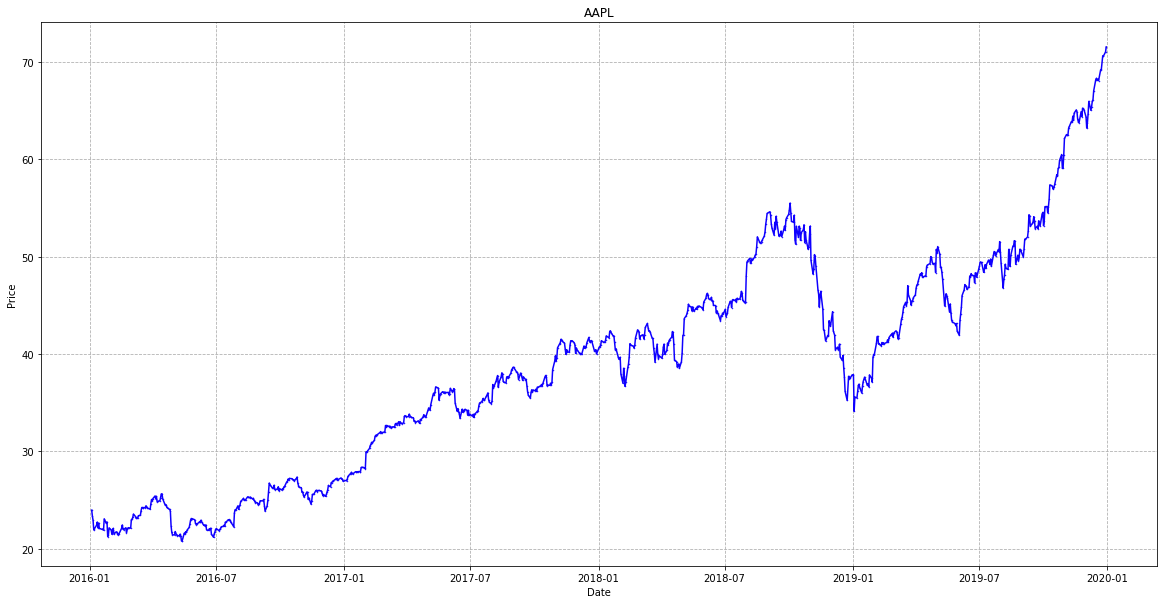

In [7]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('AAPL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.plot(_adj_close.index, _adj_close.loc[:,['AAPL']].values, marker='.', color='#0F00FF', markersize=1, linestyle='-')

-----

In [8]:
returns = ((_adj_close - _adj_close.shift(1))/_adj_close.shift(1)).iloc[1:,:]
returns.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.003440,-0.009533,-0.025059,-0.004166,-0.000233,0.003631,0.005205,0.004023,-0.007347,0.011161,...,0.018903,0.010084,0.008520,0.020387,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655
2016-01-06,0.004439,0.017522,-0.019570,0.000175,-0.008388,0.001592,-0.001954,-0.014295,-0.042561,-0.024283,...,-0.051805,0.010538,-0.008320,-0.014486,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208
2016-01-07,-0.042475,-0.018918,-0.042204,-0.002963,-0.023966,-0.001011,-0.029366,-0.020984,-0.025512,-0.023756,...,-0.094070,0.003842,-0.016007,-0.008785,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404
2016-01-08,-0.010512,-0.001977,0.005287,-0.027268,-0.020943,-0.010414,-0.009682,-0.014140,-0.008727,-0.003766,...,-0.040704,-0.010935,-0.020202,-0.028635,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605
2016-01-11,-0.016844,0.017587,0.016192,-0.031806,0.001475,-0.002046,0.010489,0.017416,0.023809,-0.006688,...,-0.016453,0.008015,-0.013389,-0.019477,-0.008437,-0.001761,-0.017233,-0.006582,-0.019919,-0.028335


-----

In [9]:
def mu(signals, window_length):
    return signals.rolling(window=window_length).mean().shift(1).iloc[window_length:,:]

def sigma(signals, window_length):
    return signals.rolling(window=window_length).std(ddof=0).shift(1).iloc[window_length:,:]

In [10]:
window_length = 20

mu_20d = mu(signals=_adj_close,
            window_length=window_length)
mu_20d.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-02,35.699902,38.157017,22.379508,40.105414,34.915261,22.386333,89.157423,88.763999,43.608846,26.977233,...,54.526070,29.146835,52.666024,53.880799,31.124693,43.408564,92.009626,58.7535,18.779999,42.078078
2016-02-03,35.529984,37.971622,22.255809,39.995936,34.708186,22.348667,89.244975,88.562999,43.477360,26.838228,...,54.221875,29.277082,52.566749,53.900410,31.069488,43.426900,91.837430,58.3255,18.569551,41.819873
2016-02-04,35.372268,37.827797,22.183432,39.998307,34.507605,22.306833,89.233538,88.345499,43.364536,26.726385,...,53.911838,29.403756,52.579202,53.848582,31.051388,43.454876,91.532775,58.0690,18.380676,41.507227
2016-02-05,35.216899,37.683495,22.142739,39.997462,34.322086,22.252667,89.258616,88.112499,43.361567,26.682047,...,53.792317,29.508192,52.660834,53.854653,31.117453,43.494295,91.220813,58.0080,18.234135,41.205012
2016-02-08,35.077960,37.506700,22.120892,39.872456,34.154482,22.199333,89.250257,87.616999,43.336118,26.664073,...,53.869602,29.625336,52.794007,53.869595,31.206142,43.529778,90.902456,57.9065,18.101841,40.941994


In [11]:
window_length = 20 

sigma_20d = sigma(signals=_adj_close,
                  window_length=window_length)
sigma_20d.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-02,1.181406,0.918134,0.634470,1.373610,1.243830,0.451677,1.891084,1.948244,1.189843,1.239599,...,4.646436,0.547284,1.095661,1.297986,0.951007,1.042575,1.753042,2.919995,1.444401,1.583285
2016-02-03,1.046438,1.071475,0.545844,1.402586,1.231479,0.434173,1.949329,1.809547,1.033309,1.201570,...,4.349910,0.644175,1.097618,1.317056,0.890872,1.069422,1.814960,2.320436,1.296077,1.551999
2016-02-04,0.875913,1.151096,0.485009,1.403658,1.175821,0.405553,1.945124,1.590687,0.880912,1.099447,...,3.914617,0.747040,1.115575,1.248627,0.861920,1.108163,1.779536,1.817360,1.116812,1.419193
2016-02-05,0.579527,1.125412,0.454774,1.403292,1.116291,0.370868,1.956670,1.521664,0.879231,1.054126,...,3.769668,0.817622,1.239707,1.255816,0.991140,1.152532,1.622691,1.692884,0.960299,1.173923
2016-02-08,0.561117,1.231505,0.473529,1.463474,1.139267,0.326947,1.965555,2.447820,0.902997,1.041701,...,3.790768,0.906778,1.376234,1.268552,1.087445,1.142708,1.823333,1.666431,0.848507,1.093763


In [13]:
signals = pd.DataFrame(np.sign(1.+np.sign(np.abs(_adj_close.loc[mu_20d.index,:].values-mu_20d.values) - 2*sigma_20d.values)),
                       columns=mu_20d.columns, 
                       index=mu_20d.index)

signals.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2016-02-08,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [14]:
signals.sum(axis=1).mean()

89.87525354969574

-----

In [15]:
def trading_signals(signals, bottom_threshold, top_threshold):
    filtered_signals = pd.DataFrame(np.zeros(shape=signals.shape))
    filtered_signals = filtered_signals.set_index(signals.index)
    filtered_signals.columns = signals.columns
    for i in range(signals.shape[0]):
        t = signals.iloc[i,:].sum()
        if t<top_threshold and t>bottom_threshold:  
            filtered_signals.iloc[i,:] = signals.iloc[i,:]  
        else:
            filtered_signals.iloc[i,:] = np.array(filtered_signals.shape[1]*[np.nan])
    filtered_signals = filtered_signals.dropna(axis=0)
    return filtered_signals

In [16]:
bottom_threshold = 10
top_threshold = 30
signals = trading_signals(signals=signals, 
                          bottom_threshold=bottom_threshold, 
                          top_threshold=top_threshold)
signals.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----

In [17]:
def optimal_portfolio(u, V, x0, risk_tolerance, turnover):
    x = cvx.Variable(u.shape[0])
    f = cvx.quad_form(x, V) - risk_tolerance*u@x + turnover*cvx.norm(x-x0, p=1) 
    prob = cvx.Problem(cvx.Minimize(f), 
                      [cvx.sum(x) == 1])
    prob.solve(solver=cvx.ECOS)
    return x.value

In [18]:
def trading_strategy(signals, returns, trading_window_length, risk_tolerance, turnover):
    portfolio_positions = pd.DataFrame(np.zeros(shape=signals.shape))
    portfolio_positions = portfolio_positions.set_index(signals.index)
    portfolio_positions.columns = signals.columns
    for i in range(signals.shape[0]):
        date = signals.index[i]
        tickers = signals.iloc[i,:].apply(lambda x:np.nan if x==0. else x).dropna().index            
        r = returns.loc[:date,:].iloc[-trading_window_length:,:].loc[:,tickers].values
        u = np.mean(r, axis=0)
        V = np.cov(r.T)  
        if i==0:
            x0 = np.ones(tickers.shape[0])/tickers.shape[0]
        else:
            x0 = portfolio_positions.iloc[i-1,:].loc[tickers].values
        x = optimal_portfolio(u, V, x0, risk_tolerance, turnover)
        if x is not None:
            portfolio_positions.loc[date,tickers] = x
        else:
            portfolio_positions.loc[date,:] = np.array(portfolio_positions.shape[1]*[np.nan])
    portfolio_positions = portfolio_positions.dropna(axis=0)
    return portfolio_positions

In [19]:
trading_window_length = 30
risk_tolerance = 1.
turnover = 1.

portfolio_positions = trading_strategy(signals=signals, 
                                       returns=returns, 
                                       trading_window_length=trading_window_length,
                                       risk_tolerance=risk_tolerance,
                                       turnover=turnover)
portfolio_positions.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0
2016-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2016-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.266743e-09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2016-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.730648e-09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2016-03-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [20]:
portfolio_positions.shape[0], np.sum(portfolio_positions.values)

(54, 53.99999997363772)

-----

In [21]:
trading_prices = _open.shift(-1).loc[portfolio_positions.index,:]
trading_prices.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-24,37.619999,40.759998,24.012501,55.169998,39.220001,23.070000,99.959999,84.760002,53.060001,34.040001,...,78.919998,39.950001,81.559998,59.139999,37.570000,51.624729,92.262138,69.370003,20.790001,42.369999
2016-02-29,37.630001,41.439999,24.412500,54.779999,38.910000,22.763332,101.379997,85.919998,53.950001,35.130001,...,84.449997,39.669998,80.559998,61.099998,37.709999,52.401150,94.174759,62.259998,21.459999,41.490002
2016-03-08,38.310001,40.740002,25.327499,55.509998,39.259998,23.026667,102.930000,84.879997,55.709999,36.279999,...,81.419998,40.639999,83.220001,61.790001,38.080002,55.427750,97.718445,63.779999,23.950001,40.549999
2016-03-09,38.169998,42.110001,25.352501,56.560001,39.410000,23.000000,103.639999,85.059998,55.459999,36.110001,...,82.739998,40.680000,82.419998,62.099998,38.009998,55.204887,98.592232,65.580002,23.840000,39.919998
2016-03-23,39.160000,41.880001,26.367500,56.139999,40.639999,23.459999,108.790001,91.500000,58.049999,36.299999,...,90.500000,41.119999,82.940002,58.770000,39.040001,57.591660,100.563110,68.480003,24.670000,42.270000


In [22]:
trading_returns = ((trading_prices - trading_prices.shift(1))/trading_prices.shift(1)).iloc[1:,:]
trading_returns.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-29,0.000266,0.016683,0.016658,-0.007069,-0.007904,-0.013293,0.014206,0.013686,0.016773,0.032021,...,0.070071,-0.007009,-0.012261,0.033142,0.003726,0.015040,0.020730,-0.102494,0.032227,-0.020769
2016-03-08,0.018071,-0.016892,0.037481,0.013326,0.008995,0.011568,0.015289,-0.012104,0.032623,0.032735,...,-0.035879,0.024452,0.033019,0.011293,0.009812,0.057758,0.037629,0.024414,0.116030,-0.022656
2016-03-09,-0.003654,0.033628,0.000987,0.018916,0.003821,-0.001158,0.006898,0.002121,-0.004488,-0.004686,...,0.016212,0.000984,-0.009613,0.005017,-0.001838,-0.004021,0.008942,0.028222,-0.004593,-0.015536
2016-03-23,0.025937,-0.005462,0.040035,-0.007426,0.031210,0.020000,0.049691,0.075711,0.046700,0.005262,...,0.093788,0.010816,0.006309,-0.053623,0.027098,0.043235,0.019990,0.044221,0.034815,0.058868
2016-03-24,0.009704,-0.021012,0.005025,0.003741,0.003199,-0.011225,0.051843,0.012896,0.009991,0.008264,...,0.033481,0.005350,0.013142,0.020759,0.019979,-0.002996,0.016219,-0.001898,0.016214,0.005205


In [23]:
portfolio_returns = np.sum(trading_returns*portfolio_positions.shift(1).iloc[1:,:], axis=1)
portfolio_returns

Date
2016-02-29    0.004629
2016-03-08    0.033256
2016-03-09   -0.000866
2016-03-23    0.013723
2016-03-24    0.008792
2016-03-28    0.007554
2016-07-19    0.548443
2016-07-20   -0.030505
2016-07-21    0.037238
2016-07-22   -0.002729
2016-11-28   -0.184090
2016-11-29    0.001976
2016-11-30   -0.029395
2016-12-02   -0.004106
2016-12-21   -0.018029
2016-12-22   -0.011106
2016-12-23    0.049861
2016-12-27    0.061708
2016-12-28   -0.115387
2016-12-29   -0.010340
2017-01-03    0.009054
2017-12-28    0.255335
2017-12-29   -0.002887
2018-02-13   -0.125000
2018-02-14    0.059042
2018-02-15   -0.048882
2018-02-16   -0.002758
2018-02-20   -0.009108
2018-02-21    0.012505
2018-02-23    0.021417
2018-02-26    0.002322
2018-02-27    0.007814
2018-02-28   -0.005525
2018-03-15    0.331325
2018-04-09   -0.056350
2018-04-13   -0.010417
2018-05-22    0.173626
2018-05-23   -0.002985
2018-10-17   -0.196272
2018-11-21    0.026736
2018-11-26    0.002972
2018-11-27   -0.005884
2019-01-02   -0.131193
2019-0

<AxesSubplot:title={'center':'Portfolio Returns'}, ylabel='Density'>

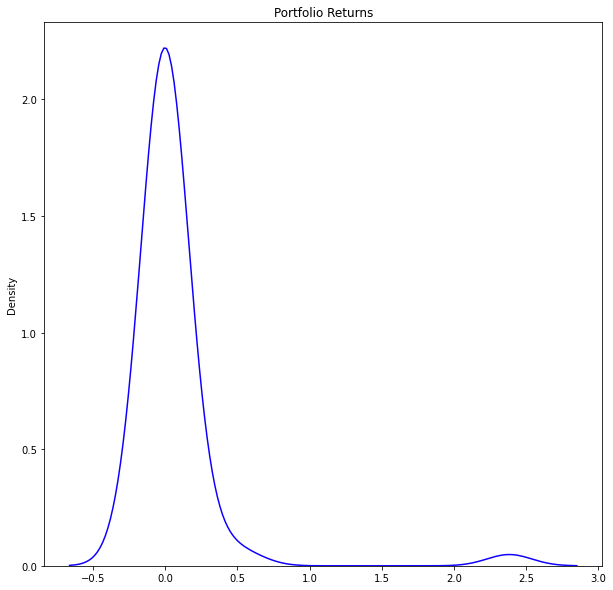

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Portfolio Returns')
sns.kdeplot(data=portfolio_returns, ax=ax, color='#0F00FF')

-----

In [25]:
discount_factor = np.cumprod(portfolio_returns+1)
discount_factor

Date
2016-02-29    1.004629
2016-03-08    1.038039
2016-03-09    1.037140
2016-03-23    1.051372
2016-03-24    1.060616
2016-03-28    1.068628
2016-07-19    1.654710
2016-07-20    1.604232
2016-07-21    1.663970
2016-07-22    1.659429
2016-11-28    1.353945
2016-11-29    1.356620
2016-11-30    1.316742
2016-12-02    1.311335
2016-12-21    1.287693
2016-12-22    1.273391
2016-12-23    1.336885
2016-12-27    1.419382
2016-12-28    1.255603
2016-12-29    1.242619
2017-01-03    1.253871
2017-12-28    1.574028
2017-12-29    1.569484
2018-02-13    1.373299
2018-02-14    1.454381
2018-02-15    1.383288
2018-02-16    1.379473
2018-02-20    1.366908
2018-02-21    1.384001
2018-02-23    1.413642
2018-02-26    1.416924
2018-02-27    1.427997
2018-02-28    1.420106
2018-03-15    1.890624
2018-04-09    1.784087
2018-04-13    1.765503
2018-05-22    2.072040
2018-05-23    2.065854
2018-10-17    1.660386
2018-11-21    1.704778
2018-11-26    1.709844
2018-11-27    1.699783
2019-01-02    1.476784
2019-0

In [26]:
start = portfolio_positions.index[0]
end = portfolio_positions.index[-1]

In [27]:
market_portfolio_positions = _adj_close.loc[start:end,:].div(_adj_close.loc[start:end,:].sum(axis=1), axis=0)
market_trading_prices = _open.shift(-1).loc[market_portfolio_positions.index,:]
market_trading_returns = ((market_trading_prices - market_trading_prices.shift(1))/market_trading_prices.shift(1)).iloc[1:,:]
market_portfolio_returns = np.sum(market_trading_returns*market_portfolio_positions.shift(1).iloc[1:,:], axis=1)
market_discount_factor = np.cumprod(market_portfolio_returns+1)

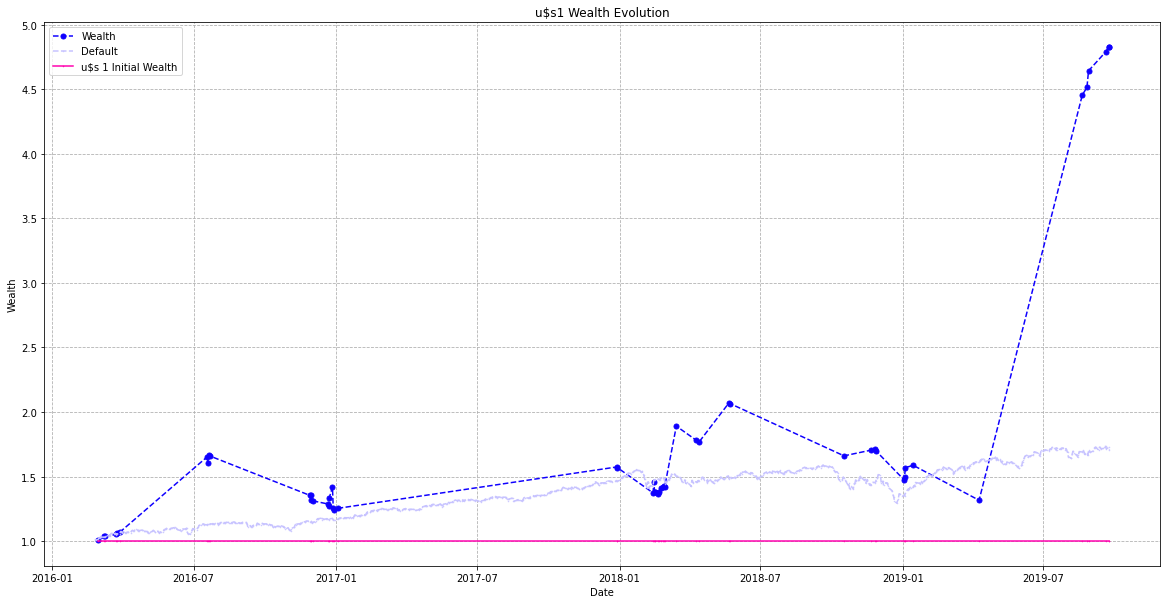

In [28]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('u$s1 Wealth Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Wealth')
ax.plot(discount_factor.index, discount_factor.values, marker='.', color='#0F00FF', markersize=10, linestyle='--', label='Wealth')
ax.plot(market_discount_factor.index, market_discount_factor.values, marker='.', color='#C7C3FF', markersize=1, linestyle='--', label='Default')
ax.plot(discount_factor.index, np.ones(discount_factor.shape), marker='.', color='#FF00AE', markersize=1, linestyle='-', label='u$s 1 Initial Wealth')
ax.legend()

In [29]:
portfolio_positions.to_csv('bollingerbands_trading.csv')

-----

In [30]:
tickers = yf.Ticker("^GSPC")

sp500 = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
sp500 = sp500.loc[:,['Adj Close']]
sp500.head()

,Adj Close
Date,
2016-02-24 00:00:00-05:00,1929.800049
2016-02-25 00:00:00-05:00,1951.699951
2016-02-26 00:00:00-05:00,1948.050049
2016-02-29 00:00:00-05:00,1932.229980
2016-03-01 00:00:00-05:00,1978.349976


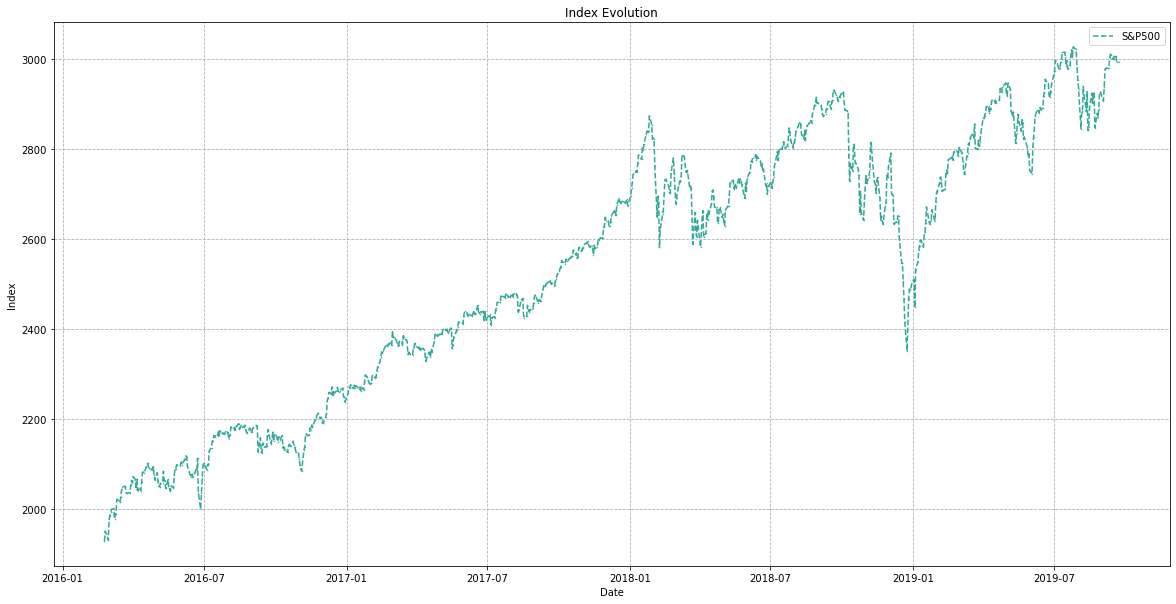

In [31]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('Index Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
ax.plot(sp500.index, sp500.loc[:,'Adj Close'].values, marker='.', color='#32A899', markersize=1, linestyle='--', label='S&P500')
ax.legend()